# Includes

In [1]:
import mujoco
import sys
import os
import math
from tqdm import tqdm
import mediapy as media
import numpy as np



# Classes and functions

In [2]:
class UR5e:
    def __init__(self, path):
        print('UR5e init.')
        self.m = mujoco.MjModel.from_xml_path(path)
        self.d = mujoco.MjData(self.m)
        self.startPos = [0, 0, 0, -math.pi/2, -math.pi/2, 0]
        for i in range(50):
            self.startPos.append(0)
        self.d.qpos = self.startPos
        mujoco.mj_forward(self.m, self.d)
        
        # Initialize OIAC parameters
        self.K = np.diag([1000.0, 1000.0, 1000.0, 500.0, 500.0, 300.0])  # Stiffness matrix (initial values)
        self.B = np.diag([3.0, 3.0, 3.0, 2.0, 2.0, 1.0])         # Damping matrix (initial values)
        self.K_adapt = 5  # Adaptation rate for stiffness
        self.B_adapt = 0.5  # Adaptation rate for damping

    def __del__(self):
        print('UR5e del.')


In [3]:
xml_path = '../Models/universal_robots_ur5e/scene.xml'
duration = 60
max_steps = int(duration/0.002)
recordVideo = True
framerate = 20

In [4]:
if 'ur5e' in locals():
    print('ur5e already exists, deleting it')
    del ur5e

try:
    ur5e
except NameError:
    print('ur5e does not exist, creating it')
    ur5e = UR5e(xml_path)


ur5e does not exist, creating it
UR5e init.


In [5]:
import os
from datetime import datetime

class Logger:
    def __init__(self, name):
        self.name = name
        self.log_data = []  # Store log values in a list instead of writing immediately

    def __del__(self):
        # Write all stored log data to the file on deletion
        try:
            with open(self.name, 'w') as file:
                for value in self.log_data:
                    file.write(f"{value}\n\n")
        except IOError as e:
            print(f"Failed to write to file: {self.name}")
            raise e

    def log_values(self, value):
        self.log_data.append(value)  # Append value to list instead of writing to file


class LoggerCollection:
    def __init__(self, result_folder):
        folder_with_timestamp = f"{result_folder}_{self.get_current_datetime()}"
        os.makedirs(f"../{folder_with_timestamp}", exist_ok=True)
        
        # Create loggers for each matrix
        self.qpos = Logger(f"../{folder_with_timestamp}/qpos.txt")
        self.qvel = Logger(f"../{folder_with_timestamp}/qvel.txt")
        self.qacc = Logger(f"../{folder_with_timestamp}/qacc.txt")
        self.K = Logger(f"../{folder_with_timestamp}/K.txt")
        self.B = Logger(f"../{folder_with_timestamp}/B.txt")
        self.gamma = Logger(f"../{folder_with_timestamp}/gamma.txt")
        self.desired_position = Logger(f"../{folder_with_timestamp}/desired_position.txt")
        self.desired_velocity = Logger(f"../{folder_with_timestamp}/desired_velocity.txt")
        self.torque = Logger(f"../{folder_with_timestamp}/torque.txt")




    def __del__(self):
        del self.qpos
        del self.qvel
        del self.qacc
        del self.K
        del self.B
        del self.gamma
        del self.desired_position
        del self.desired_velocity
        del self.torque

    @staticmethod
    def get_current_datetime():
        return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


In [6]:
class ZeroTorqueTrajectoryPlanner:
    def __init__(self, initial_positions, final_positions, duration):
        self.q_i = np.array(initial_positions)  # Initial joint positions (6 joints)
        self.q_f = np.array(final_positions)    # Final joint positions (6 joints)
        self.D = duration                       # Duration of the trajectory
        self.delta_q = self.q_f - self.q_i      # Change in joint positions

    def get_desired_position(self, t):
        if t >= self.D:
            return self.q_f
        tau = t / self.D
        scaling_factor = 10 * tau**3 - 15 * tau**4 + 6 * tau**5
        q_d = self.q_i + self.delta_q * scaling_factor
        return q_d

    def get_desired_velocity(self, t, stepsize):
        if t + stepsize > self.D:
            return np.zeros(6)
        q_d_t = self.get_desired_position(t)
        q_d_t_plus_dt = self.get_desired_position(t + stepsize)
        desired_velocity = (q_d_t_plus_dt - q_d_t) / stepsize
        return desired_velocity

In [7]:
planningduration = 1.5
secondplannerstarttime = 5

endposition = [-math.pi/2, 0, 0, -math.pi/2, -math.pi/2, 0]
planner = ZeroTorqueTrajectoryPlanner(ur5e.startPos[:6], endposition, planningduration)
planner2 = ZeroTorqueTrajectoryPlanner(endposition, ur5e.startPos[:6], planningduration/2)
desired_positions = ur5e.startPos[:6]
desired_velocities = np.zeros(6)

logger = LoggerCollection("results")

In [8]:
def mycontroller(m, d):
    # Temporarily set qvel and qacc to zero
    qpos_original = d.qpos.copy()
    qvel_original = d.qvel.copy()
    qacc_original = d.qacc.copy()
    

    # Zero the acceleration for gravity compensation
    d.qacc[:] = 0
    mujoco.mj_inverse(m, d)  # Calculate the required torques for zero acceleration under gravity
    gravity_compensation = d.qfrc_inverse[:6].copy()  # Copy the compensation torques
    passive_joint_torques = d.qfrc_passive[:6].copy()  # Copy the passive

    # Restore the original acceleration values
    d.qacc[:] = qacc_original

    # Define desired positions and velocities (this could be dynamic based on target trajectory)
    if ur5e.d.time < planningduration:
        desired_position = planner.get_desired_position(ur5e.d.time)
        desired_velocity = planner.get_desired_velocity(ur5e.d.time, 0.002)
    elif ur5e.d.time > secondplannerstarttime and ur5e.d.time < secondplannerstarttime + planningduration / 2:
        desired_position = planner2.get_desired_position(ur5e.d.time - secondplannerstarttime)
        desired_velocity = planner2.get_desired_velocity(ur5e.d.time - secondplannerstarttime, 0.002)
    elif ur5e.d.time > secondplannerstarttime + planningduration / 2:
        desired_position = ur5e.startPos[:6]
        desired_velocity = np.zeros(6)
    else:
        desired_position = endposition
        desired_velocity = np.zeros(6)

    # Calculate position and velocity errors
    position_error = desired_position - d.qpos[:6]
    velocity_error = desired_velocity - d.qvel[:6]

    # Adapt stiffness and damping matrices
    # Define parameters for adaptation
    beta = 0.9
    a = 0.01
    C = 20.0

    # Compute tracking error epsilon(t)
    epsilon = position_error + beta * velocity_error

    # Adapt impedance matrices K(t) and B(t)
    gamma = a / (1 + C * np.linalg.norm(epsilon)**2)
    ur5e.K = np.diag(epsilon * position_error / gamma)
    ur5e.B = np.diag(epsilon * velocity_error / gamma)


    # Calculate control torque with gravity compensation
    torque = ur5e.K @ position_error + ur5e.B @ velocity_error + gravity_compensation[:6] 
    d.ctrl[:6] = torque

    # Log values
    logger.qpos.log_values(qpos_original)
    logger.qvel.log_values(qvel_original)
    logger.qacc.log_values(qacc_original)
    logger.K.log_values(ur5e.K)
    logger.B.log_values(ur5e.B)
    logger.gamma.log_values(gamma)
    logger.desired_position.log_values(desired_position)
    logger.desired_velocity.log_values(desired_velocity)
    logger.torque.log_values(torque)




# Simulation

In [9]:
if 'renderer' in locals():
    print('renderer already exists')
    del renderer


try:
    renderer
except NameError:
    renderer = mujoco.Renderer(ur5e.m, 480, 640)

In [10]:
stepsize = ur5e.m.opt.timestep
mujoco.set_mjcb_control(mycontroller)


In [11]:
if 'frames' in locals():
    print('frames already exists')
    del frames

if 'progress_bar' in locals():
    print('progress_bar already exists')
    del progress_bar

idx = 0
frames = []
progress_bar = tqdm(total=duration)
while ur5e.d.time < duration and idx < max_steps:
    progress_bar.update(ur5e.m.opt.timestep)

    
    if len(frames) < ur5e.d.time * framerate and recordVideo:
        renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)

    mujoco.mj_step(ur5e.m, ur5e.d)
    idx += 1

  

  0%|          | 0/60 [00:00<?, ?it/s]

100%|█████████▉| 59.81200000002713/60 [00:41<00:00,  1.43it/s]  

In [12]:
if recordVideo:
    media.show_video(frames, fps=framerate)


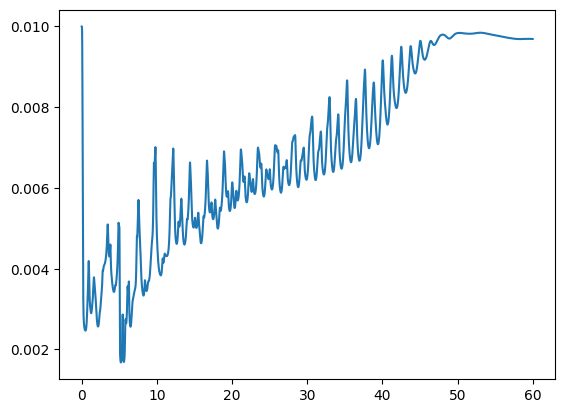

In [13]:
#plot of gamma over time
import matplotlib.pyplot as plt
import numpy as np

gamma = logger.gamma.log_data
gamma = np.array(gamma).flatten()

time = np.arange(0, len(gamma), 1)
time = time * 0.002

plt.plot(time, gamma)

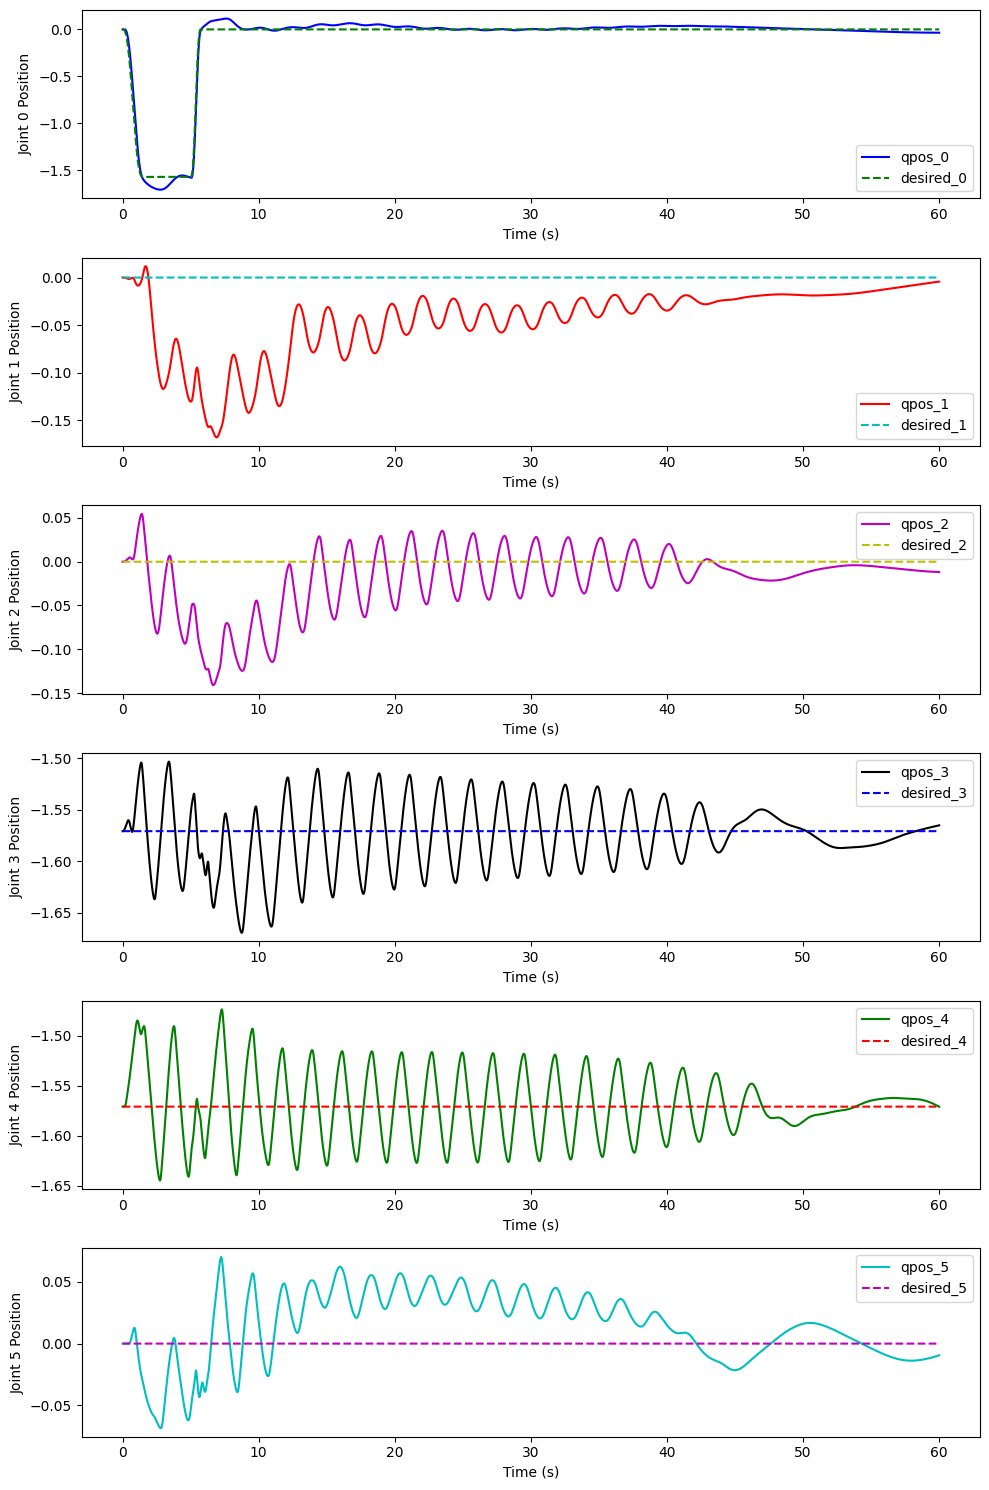

In [14]:
#plot qpos over time vs desired position
qpos = logger.qpos.log_data
qpos = np.array(qpos)
qpos = qpos[:, :6]


desired_position = logger.desired_position.log_data
desired_position = np.array(desired_position)


time = np.arange(0, len(qpos), 1)
time = time * 0.002

#12 different colors
colors = ['b', '--g', 'r', '--c', 'm', '--y', 'k', '--b', 'g', '--r', 'c', '--m']

fig, axs = plt.subplots(6, 1, figsize=(10, 15))
for i in range(6):
    axs[i].plot(time, qpos[:, i], colors[2*i], label=f"qpos_{i}")
    axs[i].plot(time, desired_position[:, i], colors[2*i+1], label=f"desired_{i}")
    axs[i].legend()
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'Joint {i} Position')

plt.tight_layout()
plt.show()


In [15]:

    
del logger  